## 0: For Colab

In [1]:
# Load and unzip data
# Download from https://drive.google.com/u/0/uc?id=1p33nsWQaiZMAgsruDoJLyatoq5XAH-TH&export=download
#from google.colab import drive
#drive.mount('/content/gdrive')
#%cd "/content/gdrive/MyDrive/Colab Notebooks/.../your_project_folder"
#!unzip "/content/gdrive/MyDrive/Colab Notebooks/.../your_project_folder/Fundus-doFE.zip" -d "/content/"

# Install additional libraries
#!pip install segmentation-models-pytorch
#!git clone https://github.com/deepmind/surface-distance.git
#!pip install surface-distance/

## 1: Import

In [2]:
# Requirements
#!pip install torchvision>=0.5.0
#!pip install pretrainedmodels==0.7.4
#!pip install efficientnet-pytorch==0.7.1
#!pip install timm==0.6.13
#!pip install tqdm
#!pip install pillow

In [1]:
# Standard library imports
import os
import shutil
import re
import gc
import random as randpy

from copy import deepcopy
from math import sqrt

# Third-party library imports
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from pylab import *
import matplotlib.pyplot as plt

# PyTorch imports for deep learning
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset

# Utilities for image data handling
from torchvision import transforms

# For segmentation models
import segmentation_models_pytorch as smp

# Metrics
from segmentation_models_pytorch.losses import DiceLoss
import surface_distance as surfdist

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 2: Fundus Dataset

**Total**: **1060** images

**Domian1**: Drishti-GS dataset (**101** images, with 50 for training and 51 for testing)

**Domain2**: RIM-ONE_r3 dataset (**159** images, with 99 for training and 60 for testing)

**Domain3**: REFUGE training dataset (**400** images, with 320 for training and 80 for testing)

**Domian4**: REFUGE validation dataset (**400** images, with 320 for training and 80 for testing)

In [2]:
# Define the path to move the data
train_path = "./train"
val_path = "./val"
test_path = "./test"

# Define the path to load the data
domain_mask_dir = [["./Fundus/Domain1/train/ROIs/mask", "./Fundus/Domain1/test/ROIs/mask"],
                   ["./Fundus/Domain2/train/ROIs/mask", "./Fundus/Domain2/test/ROIs/mask"],
                   ["./Fundus/Domain3/train/ROIs/mask", "./Fundus/Domain3/test/ROIs/mask"],
                   ["./Fundus/Domain4/train/ROIs/mask", "./Fundus/Domain4/test/ROIs/mask"]]

# Define the fundus dataset class to load the data by functions
class FundusDataset(Dataset):
    # Define the constructor
    def __init__(self, path, transform, transform_mask):
        self.path = path
        self.transform = transform
        self.transform_mask = transform_mask
        self.path_df = self.create_path_df()
    
    # Creates a DataFrame with image and mask paths
    def create_path_df(self):
        img_dirs, imgs, mask_dirs, masks = [], [], [], []
        
        for mask_dir in self.path:
            for img_path in mask_dir:
                for _, _, files in os.walk(img_path):
                    for file in files:
                        check_mask = cv2.imread(os.path.join(img_path, file))
                        
                        if check_mask.sum() > 0:
                            imgs.append(file)
                            masks.append(file)
                            mask_dirs.append(img_path+'/')
                            img_dirs.append(img_path.replace('mask','image')+'/')

        return pd.DataFrame({'img_dir':img_dirs, 'imgs':imgs, 'mask_dir':mask_dirs, 'masks':masks})
    
    # Splits the train dataset into train and validation based on the split index
    def split_traindataset(self):
        for i in range(len(self.path_df)):
            img_dir = self.path_df.loc[i]['img_dir'][:-1] + '/' + self.path_df.loc[i]['imgs']
            mask_dir = self.path_df.loc[i]['mask_dir'][:-1] + '/' + self.path_df.loc[i]['masks']
            domain = re.search(r'Domain\d', img_dir).group() if img_dir else None
            
            # Split the dataset based on the project description
            if domain:
                if domain != "Domain4":
                    destination_path = train_path if i < int(0.8 * len(self.path_df)) else val_path
                    shutil.copy(img_dir, destination_path + "/image/")
                    shutil.copy(mask_dir, destination_path + "/mask/")
                elif domain != "Domain3":
                    destination_path = train_path if i < int(0.8 * len(self.path_df)) else val_path
                    shutil.copy(img_dir, destination_path + "/image/")
                    shutil.copy(mask_dir, destination_path + "/mask/")
                elif domain != "Domain2":
                    destination_path = train_path if i < int(0.8 * len(self.path_df)) else val_path
                    shutil.copy(img_dir, destination_path + "/image/")
                    shutil.copy(mask_dir, destination_path + "/mask/")
                elif domain != "Domain1":
                    destination_path = train_path if i < int(0.8 * len(self.path_df)) else val_path
                    shutil.copy(img_dir, destination_path + "/image/")
                    shutil.copy(mask_dir, destination_path + "/mask/")

    # Moves the test dataset to the test path
    def split_testdataset(self):
        for i in range(len(self.path_df)):
            img_dir = self.path_df.loc[i]['img_dir'][:-1] + '/' + self.path_df.loc[i]['imgs']
            mask_dir = self.path_df.loc[i]['mask_dir'][:-1] + '/' + self.path_df.loc[i]['masks']
            shutil.copy(img_dir, test_path+"/image/")
            shutil.copy(mask_dir, test_path+"/mask/")

    # Returns length of the dataset
    def __len__(self):
        return len(self.path_df)

    # Load the images and masks
    def __getitem__(self):
        fundus_img_list = []
        mask_list = []
        for idx in range(len(self.path_df)):
              # Load the images
              folder = self.path_df.loc[idx]['img_dir'][:-1] + '/' + self.path_df.loc[idx]['imgs']
              fundus_img = cv2.imread(folder)
              fundus_img = self.transform(fundus_img)
              fundus_img_list.append(fundus_img)

              # Load the masks
              folder = self.path_df.loc[idx]['mask_dir'][:-1] + '/' + self.path_df.loc[idx]['masks']
              mask = cv2.imread(folder,0)
              mask = self.transform_mask(mask)
              mask_list.append(mask)
        return fundus_img_list, mask_list

    #  Creates a list of image and mask paths
    def get_path(self):
        fundus_img_paths = []
        mask_paths = []
        train_folders = os.listdir(train_path)
        for folder in train_folders:
            files = os.listdir(os.path.join(train_path, folder))
            for file in files:
                path = os.path.join(train_path, folder, file)
                if 'mask' in folder:
                    mask_paths.append(path)
                else:
                    fundus_img_paths.append(path)
        return fundus_img_paths, mask_paths

    # Store the data in tensor form
    def get_dataset(self):
        fundus_imgs, masks = self.__getitem__()
        inputs = (fundus_imgs[0])
        labels = (masks[0])
        inputs = torch.stack(fundus_imgs)
        labels = torch.stack(masks)
        dataset = TensorDataset(inputs,labels)

        return dataset

In [3]:
# Creates the train, validation, and test folders
for path in [train_path, val_path, test_path]:
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)
    os.makedirs(os.path.join(path, "image"))
    os.makedirs(os.path.join(path, "mask"))

# Normalization
normalization = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(128),
    transforms.RandomCrop(128),
    transforms.ToTensor(),
])
label_normalization = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128,128),
    interpolation=Image.NEAREST)
])

# Create the datasets
# train = 1,2,3 test = 4 <--
# train = 1,2,4 test = 3 
# train = 1,3,4 test = 2
# train = 2,3,4 test = 1
train_class = FundusDataset([domain_mask_dir[0], domain_mask_dir[1], domain_mask_dir[2]],
                            transform=normalization, transform_mask=label_normalization)
test_class = FundusDataset([domain_mask_dir[3]],
                           transform=normalization, transform_mask=label_normalization)

# Split files of system
train_class.split_traindataset()
test_class.split_testdataset()

# Prepare the datasets for Fourier augmentation later
train_dataset = train_class.get_dataset()
test_dataset = test_class.get_dataset()
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create the dataloaders for baseline experiment
train_baseline_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_baseline_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_baseline_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Display the number of images/batches
print("Dataset:")
print("Number of train images:", len(train_dataset))
print("Number of validation images:", len(val_dataset))
print("Number of test images:", len(test_dataset))
print("")
print("Baseline:")
print("Number of train batches:", len(train_baseline_loader))
print("Number of validation batches:", len(val_baseline_loader))
print("Number of test batches:", len(test_baseline_loader))

Dataset:
Number of train images: 528
Number of validation images: 132
Number of test images: 400

Baseline:
Number of train batches: 33
Number of validation batches: 9
Number of test batches: 25


## 3: Segmentation Baseline

### 3.1: U-Net

In [4]:
## Load a pre-trained U-Net model
unet_model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=3
)

### 3.2: Average Surface Distance (ASD)

In [5]:
# Implement Average Surface Distance (ASD)
def compute_asd(outputs, labels, idx, plot=False):
    # Clone the output tensors for manipulation
    outputs_img = outputs.clone()
    outputs = F.softmax(outputs, dim=1)
    outputs_cpy1, outputs_cpy2 = outputs.clone(), outputs.clone()
    labels_cpy1, labels_cpy2 = labels.clone(), labels.clone()

    # Define unique label values and some statistical metrics of the outputs
    # 0.0 0.5019607543945312 1.0
    #OC, OD, BG = torch.unique(labels)[0].item(), torch.unique(labels)[1].item(), torch.unique(labels)[2].item()
    mean, std = outputs.mean(), outputs.std()

    # Plot the images for the last validation batch
    if plot and idx+1 == len(val_baseline_loader):
        print("After:")
        _, axs = plt.subplots(1, 2)

        outputs_img = outputs_img.cpu().detach().numpy()[0]
        axs[0].imshow(outputs_img[2])
        axs[0].set_title('Output')
        axs[0].axis('off')

        labels_img = labels.cpu().detach().numpy()[0]
        axs[1].imshow(labels_img[0])
        axs[1].set_title('Label')
        axs[1].axis('off')

        plt.tight_layout()
        plt.show()

    # The color scheme (hence the label values) of labels and outputs might not match
    # Trying to match the label values might produce 0 ASD

    # Compute ASD for Optic Cup (OC)
    # Indicate the label values for OC by 2.0 and others by 0.0
    labels_cpy1[labels_cpy1 == 0.0] = 2.0   # Set OC to 2.0
    labels_cpy1[labels_cpy1 != 2.0] = 0.0   # Set the rest to 0.0
    # Set the confidence of the outputs to be within z = +/-0.5
    outputs_cpy1[outputs_cpy1 < (mean - (0.5 * std))] = 0.0
    outputs_cpy1[outputs_cpy1 > (mean + (0.5 * std))] = 0.0
    labels_np, outputs_np = process_images_for_asd(labels_cpy1, outputs_cpy1)
    surface_dist = surfdist.compute_surface_distances(labels_np, outputs_np, spacing_mm=(1.0, 1.0, 1.0))
    oc_avg_asd = surfdist.compute_average_surface_distance(surface_dist)[1]

    # Compute ASD for Optic Disk (OD)
    # Indicate the label values for OD by 1.0 and others by 0.0
    labels_cpy2[labels_cpy2 == 1.0] = 0.0   # Set the BG to be 0.0, so both OC and BG are 0.0
    labels_cpy2[labels_cpy2 != 0.0] = 1.0   # Set the rest (OD) to 1.0
    # Set the confidence of the outputs to be within z = +/-0.5
    outputs_cpy2[outputs_cpy2 < (mean - (0.5 * std))] = 0.0
    outputs_cpy2[outputs_cpy2 > (mean + (0.5 * std))] = 0.0
    labels_np, outputs_np = process_images_for_asd(labels_cpy2, outputs_cpy2)
    surface_dist = surfdist.compute_surface_distances(labels_np, outputs_np, spacing_mm=(1.0, 1.0, 1.0))
    od_avg_asd = surfdist.compute_average_surface_distance(surface_dist)[1]

    # Plot the images for the last validation batch
    if plot and idx+1 == len(val_baseline_loader):
        print("After:")
        _, axs = plt.subplots(2, 2)

        outputs_img = outputs_cpy1.cpu().detach().numpy()[0]
        axs[0, 0].imshow(outputs_img[2])
        axs[0, 0].set_title('OC - Output')
        axs[0, 0].axis('off')

        labels_img = labels_cpy1.cpu().detach().numpy()[0]
        axs[0, 1].imshow(labels_img[0])
        axs[0, 1].set_title('OC - Label')
        axs[0, 1].axis('off')

        outputs_img = outputs_cpy2.cpu().detach().numpy()[0]
        axs[1, 0].imshow(outputs_img[2])
        axs[1, 0].set_title('OD - Output')
        axs[1, 0].axis('off')

        labels_img = labels_cpy2.cpu().detach().numpy()[0]
        axs[1, 1].imshow(labels_img[0])
        axs[1, 1].set_title('OD - Label')
        axs[1, 1].axis('off')

        plt.tight_layout()
        plt.show()

    return oc_avg_asd, od_avg_asd

# Helper function to process images for ASD calculation
def process_images_for_asd(labels, outputs):
    labels_np = labels.cpu().detach().numpy().astype(np.bool_)
    labels_np = np.stack((labels_np[:, 0, :], labels_np[:, 0, :], labels_np[:, 0, :]), axis=1)
    outputs_np = outputs.cpu().detach().numpy().astype(np.bool_)
    labels_np = labels_np.reshape((1, -1, labels_np.shape[3]))
    outputs_np = outputs_np.reshape((1, -1, outputs_np.shape[3]))
    return labels_np, outputs_np

## 4: Baseline Experiment

### 4.1: Training

In [182]:
# Define the function to train the model
def train_baseline(model, train_loader, val_loader, optimizer, scheduler, criterion, device, epochs):  
    # Clear GPU cache if CUDA is available
    if torch.cuda.is_available():
        gc.collect()
        torch.cuda.empty_cache()

    # Initialize lists to store losses and dice scores
    loss_total_list = []
    dice_train_list, dice_val_list = [], []
    oc_val_list, od_val_list = [], []

    # Initialize the dice loss function
    Dice = DiceLoss(mode='multiclass', from_logits=True, smooth=1e-8)

    # Iterate over epochs
    for epoch in range(epochs):
        loss_total_train, dice_total_train =\
            train_epoch(model, train_loader, optimizer, criterion, device, Dice)
        loss_total_list.append(loss_total_train)
        dice_train_list.append(dice_total_train)

        dice_total_val, oc_asd_val, od_asd_val = validate_epoch(model, val_loader, device, Dice)
        dice_val_list.append(dice_total_val)
        oc_val_list.append(oc_asd_val)
        od_val_list.append(od_asd_val)

        scheduler.step()

        # Print training progress
        print(f"Epoch [{epoch+1:02}/{epochs}],   "
              f"Loss: {loss_total_list[-1]:.4f},   "
              f"Train Dice: {dice_train_list[-1]:.4f},   "
              f"Val Dice: {dice_val_list[-1]:.4f},   "
              f"OC Val ASD: {oc_val_list[-1]:.4f}   "
              f"OD Val ASD: {od_val_list[-1]:.4f}")

        # Clear GPU cache if CUDA is available
        if torch.cuda.is_available():
            gc.collect()
            torch.cuda.empty_cache()

    return model, loss_total_list, dice_train_list, dice_val_list, (oc_val_list, od_val_list)


# Define the functions train_epoch and validate_epoch for training and validation of a single epoch
# Training for one epoch  
def train_epoch(model, train_loader, optimizer, criterion, device, Dice):  
    model.train()
    loss_total, dice_total = 0, 0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        scores = model(inputs)
        labels += 1
        labels_hot = F.one_hot(labels[:, 0, :].long(), 3)
        loss = criterion(F.softmax(scores, dim=1), labels_hot.permute(0, 3, 1, 2).to(torch.float32))
        dice_loss = Dice(scores, labels.long())
        dice_coeff = 1 - dice_loss

        loss.backward()
        optimizer.step()

        loss_total += loss.item()
        dice_total += dice_coeff.item()
    
    return loss_total / len(train_loader), dice_total / len(train_loader)

# Validation for one epoch
def validate_epoch(model, val_loader, device, Dice):
    model.eval()
    dice_total, oc_asd_total, od_asd_total = 0, 0, 0
    
    for idx, (inputs, labels) in enumerate(val_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        scores = model(inputs)

        labels += 1
        dice_loss = Dice(scores, labels.long())
        labels -= 1
        oc_asd, od_asd = compute_asd(scores, labels, idx)
        dice_coeff = 1 - dice_loss

        dice_total += dice_coeff.item()
        oc_asd_total += oc_asd
        od_asd_total += od_asd
    
    return dice_total / len(val_loader), oc_asd_total / len(val_loader), od_asd_total / len(val_loader)


base_model = unet_model.to(device)
optimizer = Adam(base_model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

epochs = 15
scheduler = CosineAnnealingLR(optimizer=optimizer, T_max=epochs)

# Run training
base_model, loss_total_list, dice_train_list, dice_val_list, asd_val_list = train_baseline(
    base_model, train_baseline_loader, val_baseline_loader, optimizer, scheduler,
    criterion, device, epochs=epochs)

Epoch [01/15],   Loss: 0.6301,   Train Dice: 0.8928,   Val Dice: 0.9054,   OC Val ASD: 35.1001   OD Val ASD: 24.4663
Epoch [02/15],   Loss: 0.6066,   Train Dice: 0.9251,   Val Dice: 0.9312,   OC Val ASD: 35.8304   OD Val ASD: 24.9798
Epoch [03/15],   Loss: 0.5926,   Train Dice: 0.9430,   Val Dice: 0.9455,   OC Val ASD: 35.9279   OD Val ASD: 25.0662
Epoch [04/15],   Loss: 0.5840,   Train Dice: 0.9540,   Val Dice: 0.9540,   OC Val ASD: 36.0187   OD Val ASD: 25.1566
Epoch [05/15],   Loss: 0.5784,   Train Dice: 0.9612,   Val Dice: 0.9593,   OC Val ASD: 36.0490   OD Val ASD: 25.1882
Epoch [06/15],   Loss: 0.5746,   Train Dice: 0.9663,   Val Dice: 0.9629,   OC Val ASD: 36.0741   OD Val ASD: 25.2170
Epoch [07/15],   Loss: 0.5720,   Train Dice: 0.9698,   Val Dice: 0.9654,   OC Val ASD: 36.0836   OD Val ASD: 25.2223
Epoch [08/15],   Loss: 0.5698,   Train Dice: 0.9727,   Val Dice: 0.9667,   OC Val ASD: 36.0963   OD Val ASD: 25.2426
Epoch [09/15],   Loss: 0.5682,   Train Dice: 0.9751,   Val Dice:

### 4.2: Results

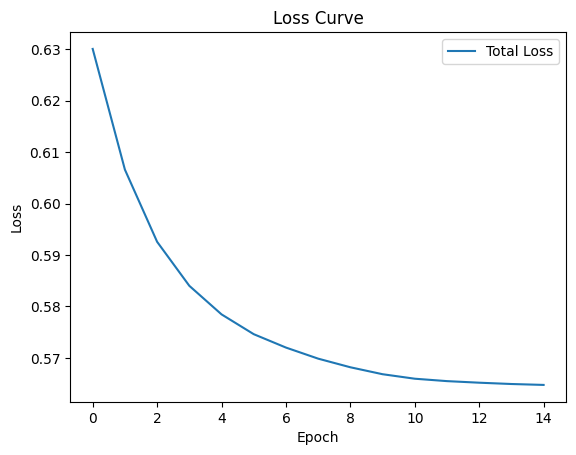

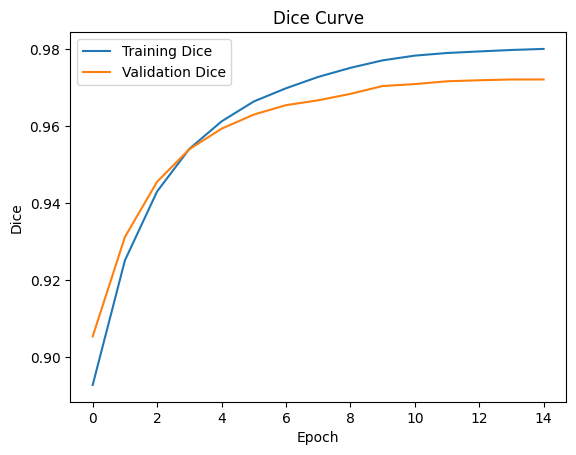

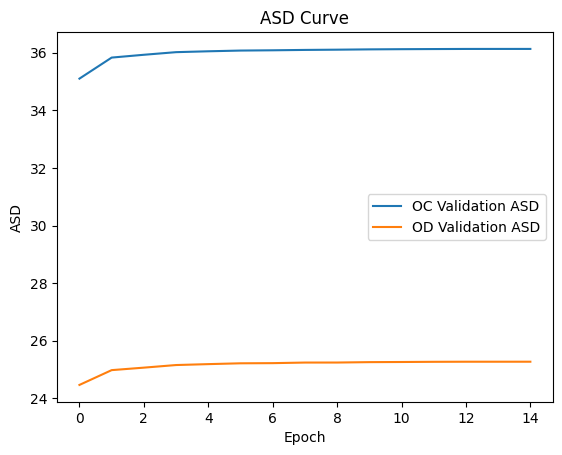

In [183]:
# Plot loss curve
fig = plt.figure()
plt.plot(loss_total_list, label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Plot accuracy curve
fig = plt.figure()
plt.plot(dice_train_list, label='Training Dice')
plt.plot(dice_val_list, label='Validation Dice')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.title('Dice Curve')
plt.legend()
plt.show()

# Plot AUC curve
fig = plt.figure()
plt.plot(asd_val_list[0], label='OC Validation ASD')
plt.plot(asd_val_list[1], label='OD Validation ASD')
plt.xlabel('Epoch')
plt.ylabel('ASD')
plt.title('ASD Curve')
plt.legend()
plt.show()

### 4.3: Evaluation

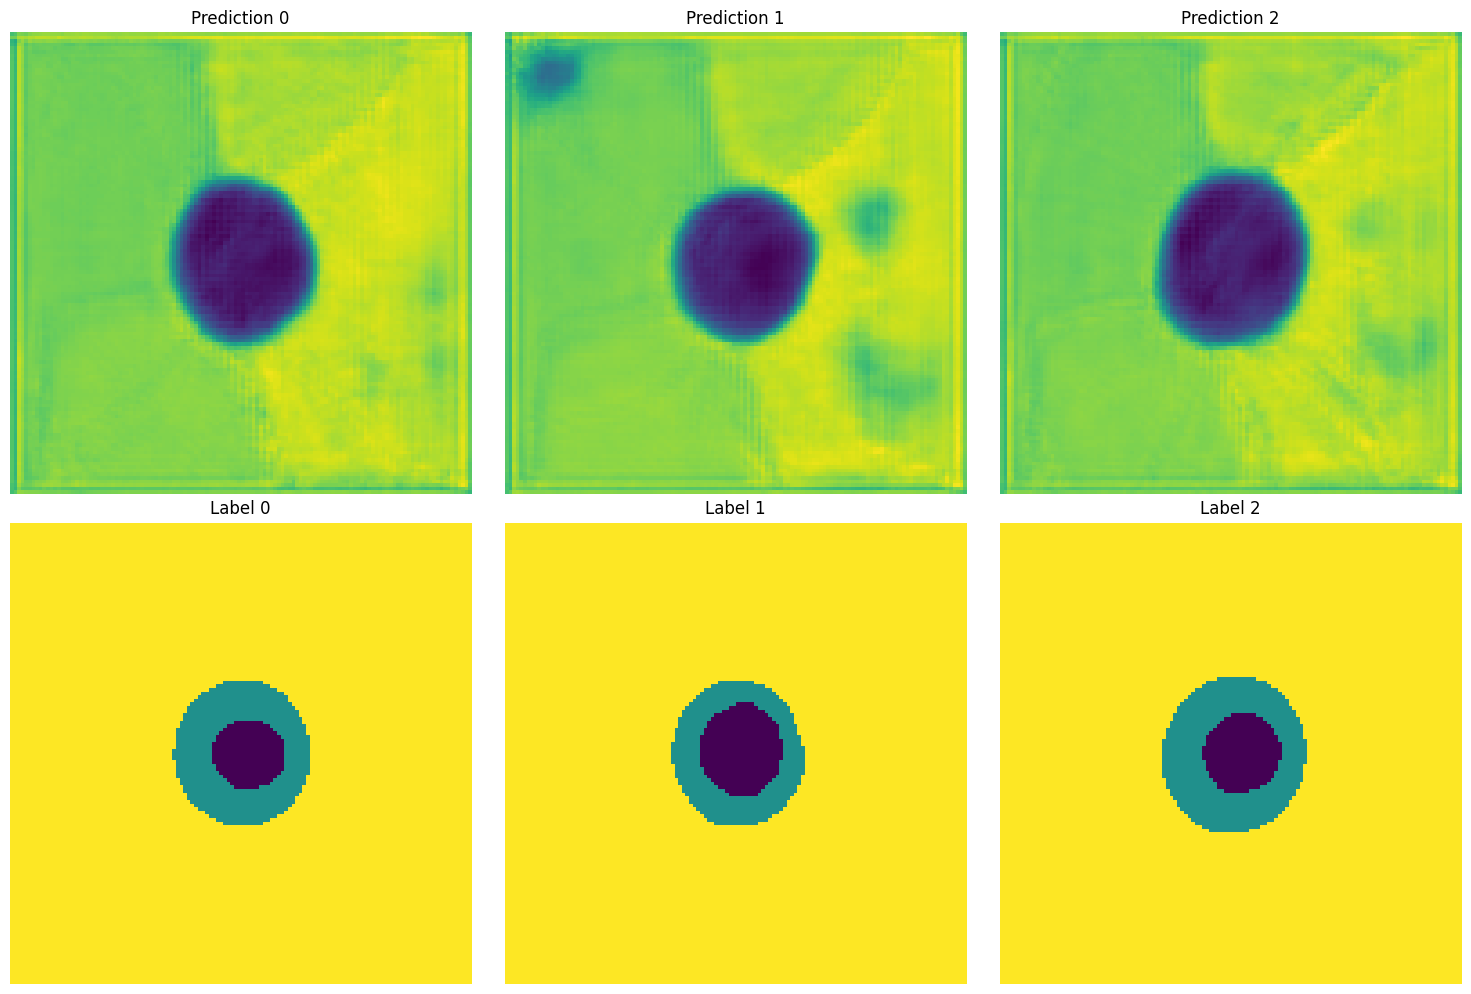

Mean Test Dice: 0.5954,   OC Val ASD: 37.7678   OD Val ASD: 28.9538


In [184]:
Dice = DiceLoss(mode='multiclass', from_logits=True, smooth=1e-8)
base_model.eval()
dice_total_test, oc_asd_val, od_asd_val = 0, 0, 0

# Create a 3x2 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Run testing
for it, (inputs, labels) in enumerate(test_baseline_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    scores = base_model(inputs) / 10.0

    labels += 1
    loss = criterion(scores, labels[:, 0, :].long())
    dice_loss = Dice(scores, labels.long())
    labels -= 1
    oc_asd, od_asd = compute_asd(scores, labels, it)
    dice_coeff = 1 - dice_loss
    
    dice_total_test += dice_coeff.item()
    oc_asd_val += oc_asd
    od_asd_val += od_asd

    # Plot predictions and corresponding masks
    if it < 3:
        axs[0, it].imshow(scores[0, 2].detach().cpu().numpy())
        axs[0, it].set_title(f"Prediction {it}")
        axs[0, it].axis('off')

        axs[1, it].imshow(labels[0, 0].detach().cpu().numpy())
        axs[1, it].set_title(f"Label {it}")
        axs[1, it].axis('off')

plt.tight_layout()
plt.show()

# Metrics
mean_test_dice = dice_total_test / len(test_baseline_loader)
oc_val_asd = oc_asd_val / len(test_baseline_loader)
od_val_asd = od_asd_val / len(test_baseline_loader)

print(f"Mean Test Dice: {mean_test_dice:.4f},   "
      f"OC Val ASD: {oc_val_asd:.4f}   "
      f"OD Val ASD: {od_val_asd:.4f}")

## 5: FACT

### 5.1: Utilities

FACT/data/data_utils.py (modified)

https://github.com/MediaBrain-SJTU/FACT/blob/main/data/data_utils.py

In [6]:
# Retrieve all the image and mask file directories from a given filepath
def dataset_info(filepath):
    img_direcs = []
    mask_direcs = []
    for folder in os.listdir(filepath):
        files = os.listdir(filepath+'/'+folder)
        for file in files:
            direc = filepath+'/'+folder+'/'+file
            if 'mask' in direc: mask_direcs.append(direc)
            else: img_direcs.append(direc)
    return img_direcs, mask_direcs

# Get the transformations to be applied to the images during training
def get_img_transform(train=False, image_size=224, crop=False, jitter=0):
    mean = [0.5]
    std = [0.5]
    if train:
        if crop:
            img_transform = [transforms.ToPILImage(),transforms.RandomResizedCrop(image_size, scale=[0.8, 1.0])]
        else:
            img_transform = [transforms.ToPILImage(),transforms.Resize((image_size, image_size))]
        if jitter > 0:
            img_transform.append(transforms.ColorJitter(brightness=jitter,
                                                        contrast=jitter,
                                                        saturation=jitter,
                                                        hue=min(0.5, jitter)))
        img_transform += [transforms.RandomHorizontalFlip(),
                          transforms.Normalize(mean, std)]
        img_transform = transforms.Compose(img_transform)
    else:
        img_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    return img_transform

# Get the transformations to be applied to the labels during training
def get_label_transform(train=False, image_size=224, crop=False, jitter=0):
    mean = [0.5]
    std = [0.5]
    if train:
        if crop:
            label_transform = [transforms.ToPILImage(),transforms.RandomResizedCrop(image_size, scale=[0.8, 1.0], interpolation=Image.NEAREST)]
        else:
            label_transform = [transforms.ToPILImage(),transforms.Resize((image_size, image_size), interpolation=Image.NEAREST)]
        label_transform += [transforms.RandomHorizontalFlip(),
                          transforms.ToTensor(),
                          transforms.Normalize(mean, std)]
        label_transform = transforms.Compose(label_transform)
    else:
        label_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((image_size, image_size), interpolation=Image.NEAREST),
        ])
    return label_transform
    
# Gets the preprocessing transformations to be applied to the images before training
def get_pre_transform(image_size=224, crop=False, jitter=0):
    if crop:
        img_transform = [transforms.ToPILImage(), transforms.RandomResizedCrop(image_size, scale=[0.8, 1.0])]
    else:
        img_transform = [transforms.ToPILImage(), transforms.Resize((image_size, image_size))]
    if jitter > 0:
        img_transform.append(transforms.ColorJitter(brightness=jitter,
                                                    contrast=jitter,
                                                    saturation=jitter,
                                                    hue=min(0.5, jitter)))
    img_transform += [transforms.RandomHorizontalFlip(), lambda x: np.asarray(x)]
    img_transform = transforms.Compose(img_transform)
    return img_transform

# Get the postprocessing transformations to be applied to the images after training
def get_post_transform(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    img_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    return img_transform

# Apply a mix of colorful spectrum to two images
def colorful_spectrum_mix(img1, img2, alpha, ratio=1.0):
    """Input image size: ndarray of [H, W, C]"""
    lam = np.random.uniform(0, alpha)

    assert img1.shape == img2.shape
    h, w, c = img1.shape
    h_crop = int(h * sqrt(ratio))
    w_crop = int(w * sqrt(ratio))
    h_start = h // 2 - h_crop // 2
    w_start = w // 2 - w_crop // 2

    img1_fft = np.fft.fft2(img1, axes=(0, 1))
    img2_fft = np.fft.fft2(img2, axes=(0, 1))
    img1_abs, img1_pha = np.abs(img1_fft), np.angle(img1_fft)
    img2_abs, img2_pha = np.abs(img2_fft), np.angle(img2_fft)

    img1_abs = np.fft.fftshift(img1_abs, axes=(0, 1))
    img2_abs = np.fft.fftshift(img2_abs, axes=(0, 1))

    img1_abs_ = np.copy(img1_abs)
    img2_abs_ = np.copy(img2_abs)
    img1_abs[h_start:h_start + h_crop, w_start:w_start + w_crop] = \
        lam * img2_abs_[h_start:h_start + h_crop, w_start:w_start + w_crop] + (1 - lam) * img1_abs_[
                                                                                          h_start:h_start + h_crop,
                                                                                          w_start:w_start + w_crop]
    img2_abs[h_start:h_start + h_crop, w_start:w_start + w_crop] = \
        lam * img1_abs_[h_start:h_start + h_crop, w_start:w_start + w_crop] + (1 - lam) * img2_abs_[
                                                                                          h_start:h_start + h_crop,
                                                                                          w_start:w_start + w_crop]

    img1_abs = np.fft.ifftshift(img1_abs, axes=(0, 1))
    img2_abs = np.fft.ifftshift(img2_abs, axes=(0, 1))

    img21 = img1_abs * (np.e ** (1j * img1_pha))
    img12 = img2_abs * (np.e ** (1j * img2_pha))
    img21 = np.real(np.fft.ifft2(img21, axes=(0, 1)))
    img12 = np.real(np.fft.ifft2(img12, axes=(0, 1)))
    img21 = np.uint8(np.clip(img21, 0, 255))
    img12 = np.uint8(np.clip(img12, 0, 255))

    return img21, img12

### 5.2: Fourier Augmentation

FACT/data/DGDataReader.py (modified)

https://github.com/MediaBrain-SJTU/FACT/blob/main/data/DGDataReader.py

In [7]:
# Custom dataset class for the DG dataset
class DGDataset(Dataset):
    # Initialize the dataset with images, labels, and transformers
    def __init__(self, names, labels, transformer=None, lbl_transformer=None):
        self.names = names
        self.labels = labels
        self.transformer = transformer
        self.lbl_transformer = lbl_transformer

    def __len__(self):
        return len(self.names)

    # Return the transformed image and its corresponding label
    def __getitem__(self, index):
        img_name = self.names[index]
        mask_name = self.labels[index]
        img = cv2.imread(img_name).copy()
        mask = cv2.imread(mask_name).copy()
        if self.transformer is not None:
            img = self.transformer(img)
            mask = self.lbl_transformer(mask)
        return img, mask

# Custom dataset class for the Fourier augmented DG dataset
class FourierDGDataset(Dataset):
    # Initializes the dataset with images, labels, transformers, and other Fourier transform parameters
    def __init__(self, names, labels, transformer=None, lbl_transformer=None, from_domain=None, alpha=1.0):
        self.names = names
        self.labels = labels
        self.transformer = transformer
        self.lbl_transformer = lbl_transformer
        self.post_transform = get_post_transform()
        self.from_domain = from_domain
        self.alpha = alpha
        
        self.flat_names = []
        self.flat_labels = []
        self.flat_domains = []
        for i in range(len(names)):
            self.flat_domains += [i] * len(names[i])
            self.flat_names += names[i]
            self.flat_labels += labels[i]

    def __len__(self):
        return len(self.names)

    # Return the Fourier transformed image and its corresponding label
    def __getitem__(self, index):
        img_name = self.names[index]
        mask_name = self.labels[index]
        img = cv2.imread(img_name).copy()
        mask = cv2.imread(mask_name).copy()
        seed = np.random.randint(225)
        randpy.seed(seed)
        torch.manual_seed(seed)
        img_o = self.transformer(img)
        randpy.seed(seed)
        torch.manual_seed(seed)
        mask_o = self.lbl_transformer(mask)

        img_s, mask_s, _ = self.sample_image()
        img_s2o, img_o2s = colorful_spectrum_mix(img_o, img_s, alpha=self.alpha) 
        img_o, img_s = self.post_transform(img_o), self.post_transform(img_s)
        img_s2o, img_o2s = self.post_transform(img_s2o), self.post_transform(img_o2s)
        img = [img_o, img_s, img_s2o, img_o2s]
        mask = [mask_o, mask_s, mask_o, mask_s]
        return img, mask

    # Randomly sample an image from the dataset for the Fourier transform
    def sample_image(self, domain=None):
        if self.from_domain == 'all':
            domain_idx = randpy.randint(0, len(self.names)-1)
        elif self.from_domain == 'inter':
            domains = list(range(len(self.names)))
            domain_idx = randpy.sample(domains, 1)[0]
        elif self.from_domain == 'intra':
            domain_idx = domain
        else:
            raise ValueError("Not implemented")
        img_idx = randpy.randint(0, len(self.names[domain_idx])-1)
        imgn_ame_sampled = self.names[img_idx]
        img_sampled = cv2.imread(imgn_ame_sampled)
        seed = np.random.randint(225)
        randpy.seed(seed)
        torch.manual_seed(seed)
        img_sampled = self.transformer(img_sampled)
        label_ame_sampled = self.labels[img_idx]
        label_sampled = cv2.imread(label_ame_sampled)
        randpy.seed(seed)
        torch.manual_seed(seed)
        label_sampled = self.lbl_transformer(label_sampled)
        return img_sampled, label_sampled, domain_idx

# Create an instance of the DGDataset
def get_dataset(path, train=False, image_size=128, crop=False, jitter=0):
    names, labels = dataset_info(path)
    img_transform = get_img_transform(train, image_size, crop, jitter)
    lbl_transform = get_label_transform(train, image_size=image_size, crop=crop, jitter=jitter)
    return DGDataset(names, labels, img_transform, lbl_transform)

# Create an instance of the Fourier augmented DGDataset
def get_fourier_dataset(path, image_size=128, crop=False, jitter=0, from_domain='all', alpha=1.0):
    names, labels = dataset_info(path)
    img_transform = get_pre_transform(image_size, crop, jitter)
    lbl_transform = get_label_transform(train=True, image_size=image_size, crop=crop, jitter=jitter)
    return FourierDGDataset(names, labels, img_transform, lbl_transform, from_domain, alpha)

In [8]:
# Create the dataloaders
train_fourier_dataset = get_fourier_dataset(path=train_path, crop=True, jitter=0.0)
val_dataset = get_dataset(path=val_path, train=False)
test_dataset = get_dataset(path=test_path, train=False)

train_fourier_loader = DataLoader(train_fourier_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Print some information about the dataset
print(f'Shape of image: {train_fourier_loader.dataset[0][0][0].numpy().shape}')
print(f'Number of training batches: {len(train_fourier_loader)}')
print(f'Number of validation batches: {len(val_loader)}')
print(f'Number of test batches: {len(test_loader)}')

Shape of image: (3, 128, 128)
Number of training batches: 33
Number of validation batches: 9
Number of test batches: 25


### 5.3: Mean Teacher Model

In [9]:
# Mean Teacher Model
# Student model would be ResNet50 model
class MeanTeacherModel(nn.Module):
    # Core
    def __init__(self, student_model, ema_decay):
        super().__init__()
        self.student_model = student_model
        self.teacher_model = deepcopy(student_model)
        self.ema_decay = ema_decay

    def forward(self, x):
        return self.student_model(x)

    def update_teacher_model(self, current_epoch, momentum=0.9995):
        # The momentum increases from 0 to ema_decay
        # Useful for improving quickly at the beginning
        momentum = min(1 - 1 / (current_epoch + 1), self.ema_decay)
        with torch.no_grad():
            for student_params, teacher_params in zip(self.student_model.parameters(), self.teacher_model.parameters()):
                teacher_params.data.mul_(momentum).add_((1 - momentum) * student_params.data)

    # Adjust the weight of the consistency loss to rely on teacher's prediction
    # The weight factor decreases from 1 to 0 during the first certain epochs
    def sigmoid_rampup(self, current_epoch, rampup_len=5):
        current_epoch = np.clip(current_epoch, 0.0, rampup_len)
        phase = 1.0 - current_epoch / rampup_len
        return np.exp(-5.0 * phase * phase).astype(np.float32)

    # The weight decreases from some value
    def get_consistency_weight(self, epoch):
        return 1 * self.sigmoid_rampup(epoch)

### 5.4: Training

In [11]:
def train_FACT(model, train_loader, val_loader, optimizer, scheduler,
               consistency_criterion, supervised_criterion, device, epochs):
    # Clear GPU cache
    if torch.cuda.is_available():
        gc.collect()
        torch.cuda.empty_cache()

    loss_total_list, loss_sup_list, loss_con_list = [], [], []
    dice_train_list = []
    dice_val_list, oc_val_list, od_val_list = [], [], []

    for epoch in range(epochs):
        # Training
        model.student_model.train()
        model.teacher_model.train()
        loss_total_train, dice_total_train, loss_sup_train, loss_con_train = 0, 0, 0, 0
        for it, (batch, label) in enumerate(train_loader):
            batch = torch.cat(batch, dim=0).to(device)
            label = torch.cat(label, dim=0).to(device)

            optimizer.zero_grad()

            # Get predictions
            scores = model.student_model(batch)
            with torch.no_grad():
                scores_teacher = model.teacher_model(batch)

            # Split data and predictions into original and augmented parts
            assert batch.size(0) % 2 == 0
            split_idx = int(batch.size(0) / 2)
            scores_ori, scores_aug = torch.split(scores, split_idx)
            scores_ori_tea, scores_aug_tea = torch.split(scores_teacher, split_idx)
            scores_ori_tea, scores_aug_tea = scores_ori_tea.detach(), scores_aug_tea.detach()
            labels_ori, labels_aug = torch.split(label, split_idx)
            assert scores_ori.size(0) == scores_aug.size(0)
            
            # One-hot encoding
            labels_ori += 1
            labels_aug += 1
            labels_ori_hot = F.one_hot(labels_ori[:, 0, :].long(), 3)
            labels_aug_hot = F.one_hot(labels_aug[:, 0, :].long(), 3)
            loss_cls = supervised_criterion(scores_ori, labels_ori_hot.permute(0, 3, 1, 2).to(torch.float32))
            loss_aug = supervised_criterion(scores_aug, labels_aug_hot.permute(0, 3, 1, 2).to(torch.float32))
            dice_loss_cls = Dice(scores_ori, labels_ori[:, 0, :].long())
            dice_loss_aug = Dice(scores_aug, labels_aug[:, 0, :].long())

            # KL divergence
            #pred_ori, pred_aug = F.softmax(scores_ori / 10.0, dim=1), F.softmax(scores_aug / 10.0, dim=1)
            #pred_ori_tea, pred_aug_tea = F.softmax(scores_ori_tea / 10.0, dim=1), F.softmax(scores_aug_tea / 10.0, dim=1)
            #loss_ori_tea = consistency_criterion(pred_aug.log(), pred_ori_tea, reduction='batchmean')
            #loss_aug_tea = consistency_criterion(pred_ori.log(), pred_aug_tea, reduction='batchmean')

            # MSE Loss
            loss_ori_tea = consistency_criterion(scores_aug, scores_ori_tea)
            loss_aug_tea = consistency_criterion(scores_ori, scores_aug_tea)

            const_weight = model.get_consistency_weight(epoch)

            # Compute total loss
            train_dice_coeff = 0.5 * (1 - dice_loss_cls) + 0.5 * (1 - dice_loss_aug)
            total_loss = 0.5 * loss_cls + 0.5 * loss_aug +\
                         const_weight * loss_ori_tea + const_weight * loss_aug_tea

            # Backward pass and update weights
            total_loss.backward()
            optimizer.step()

            # Update teacher model parameters
            model.update_teacher_model(current_epoch=epoch)
            loss_total_train += total_loss.item()
            loss_sup_train += 0.5 * loss_cls.item() + 0.5 * loss_aug.item()
            loss_con_train += const_weight * loss_aug_tea.item() + const_weight * loss_ori_tea.item()
            dice_total_train += train_dice_coeff.item()
    
        loss_total_list.append(loss_total_train / len(train_loader))
        loss_sup_list.append(loss_sup_train / len(train_loader))
        loss_con_list.append(loss_con_train / len(train_loader))
        dice_train_list.append(dice_total_train / len(train_loader))


        ## Validation
        model.student_model.eval()
        dice_total_val, oc_asd_val, od_asd_val = 0, 0, 0
        for it, (batch) in enumerate(val_loader):
            data, labels = batch[0].to(device), batch[1].to(device)
            scores = model.student_model(data)

            labels += 1 # for one-hot encoding
            dice_loss = Dice(scores, labels[:, 0, :].long())
            labels -= 1
            oc_asd, od_asd = compute_asd(scores, labels, it)
            
            # Metrics
            val_dice_coeff = 1 - dice_loss
            dice_total_val += val_dice_coeff.item()
            oc_asd_val += oc_asd
            od_asd_val += od_asd

        dice_val_list.append(dice_total_val / len(val_loader))
        oc_val_list.append(oc_asd_val / len(val_loader))
        od_val_list.append(od_asd_val / len(val_loader))

        scheduler.step()

        # Epoch summary
        print(f"Epoch [{epoch+1:02}/{epochs}],   "
              f"Total Loss: {loss_total_list[-1]:.4f} ({loss_sup_list[-1]:.4f} + {loss_con_list[-1]:.4f}),   "
              f"Mean Train Dice: {dice_train_list[-1]:.4f},   "
              f"Mean Val Dice: {dice_val_list[-1]:.4f},   "
              f"OC Val ASD: {oc_val_list[-1]:.4f}   "
              f"OD Val ASD: {od_val_list[-1]:.4f}")

        # Clear GPU cache
        if torch.cuda.is_available():
            gc.collect()
            torch.cuda.empty_cache()

    return model, loss_total_list, loss_sup_list, loss_con_list,\
           dice_train_list, dice_val_list, (oc_val_list, od_val_list)

# Load U-Net model as Student model and Mean Teacher model
base_model = unet_model.to(device)
FACT_model = MeanTeacherModel(base_model, ema_decay=0.99).to(device)

# Optimizer, loss functions and scheduler
optimizer = Adam(FACT_model.parameters(), lr=1e-3, weight_decay=1e-5)
#consistency_criterion = F.kl_div
consistency_criterion = nn.MSELoss()
#supervised_criterion = DiceLoss(mode='multiclass', from_logits=True)
supervised_criterion = nn.CrossEntropyLoss()
Dice = DiceLoss(mode='multiclass', from_logits=True, smooth=1e-8)

epochs = 15
scheduler = CosineAnnealingLR(optimizer=optimizer, T_max=epochs)

# Run training
FACT_model, loss_total_list, loss_sup_list, loss_con_list,\
    dice_train_list, dice_val_list, asd_val_list = train_FACT(
    FACT_model, train_fourier_loader, val_loader, optimizer, scheduler,
    consistency_criterion, supervised_criterion, device, epochs=epochs)

Epoch [01/15],   Total Loss: 0.5049 (0.4985 + 0.0064),   Mean Train Dice: 0.4669,   Mean Val Dice: 0.8202,   OC Val ASD: 33.4489   OD Val ASD: 22.8041
Epoch [02/15],   Total Loss: 0.1406 (0.1162 + 0.0244),   Mean Train Dice: 0.7371,   Mean Val Dice: 0.8403,   OC Val ASD: 34.1716   OD Val ASD: 23.2422
Epoch [03/15],   Total Loss: 0.1067 (0.0771 + 0.0296),   Mean Train Dice: 0.8127,   Mean Val Dice: 0.8767,   OC Val ASD: 34.4449   OD Val ASD: 23.4928
Epoch [04/15],   Total Loss: 0.1066 (0.0693 + 0.0373),   Mean Train Dice: 0.8282,   Mean Val Dice: 0.8979,   OC Val ASD: 35.0008   OD Val ASD: 24.0819
Epoch [05/15],   Total Loss: 0.1086 (0.0656 + 0.0430),   Mean Train Dice: 0.8342,   Mean Val Dice: 0.9104,   OC Val ASD: 35.0370   OD Val ASD: 24.0449
Epoch [06/15],   Total Loss: 0.1003 (0.0639 + 0.0364),   Mean Train Dice: 0.8376,   Mean Val Dice: 0.9078,   OC Val ASD: 34.9435   OD Val ASD: 23.9789
Epoch [07/15],   Total Loss: 0.0869 (0.0606 + 0.0264),   Mean Train Dice: 0.8432,   Mean Val D

### 5.5: Results

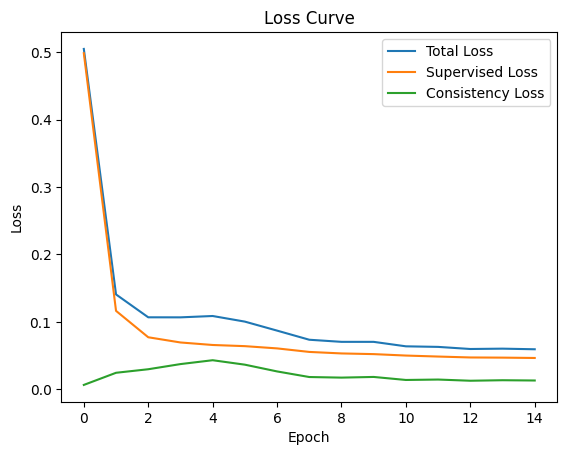

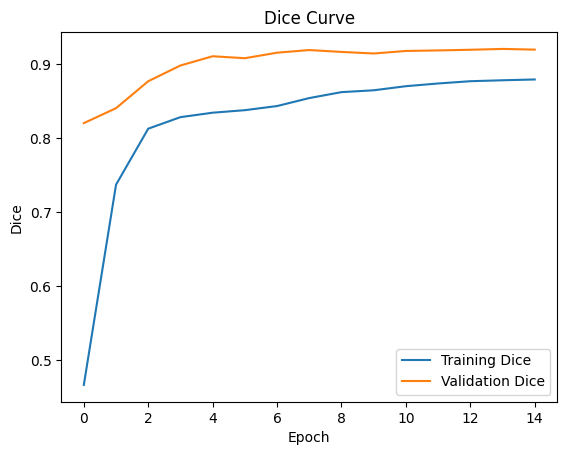

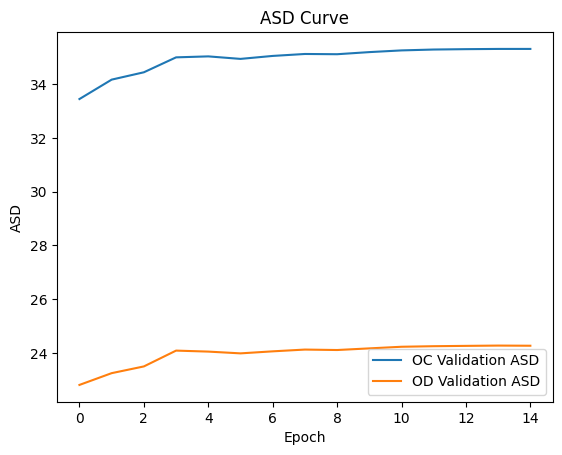

In [12]:
# Plot loss curve
fig = plt.figure()
plt.plot(loss_total_list, label='Total Loss')
plt.plot(loss_sup_list, label='Supervised Loss')
plt.plot(loss_con_list, label='Consistency Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Plot accuracy curve
fig = plt.figure()
plt.plot(dice_train_list, label='Training Dice')
plt.plot(dice_val_list, label='Validation Dice')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.title('Dice Curve')
plt.legend()
plt.show()

# Plot AUC curve
fig = plt.figure()
plt.plot(asd_val_list[0], label='OC Validation ASD')
plt.plot(asd_val_list[1], label='OD Validation ASD')
plt.xlabel('Epoch')
plt.ylabel('ASD')
plt.title('ASD Curve')
plt.legend()
plt.show()

### 5.6: Evaluation

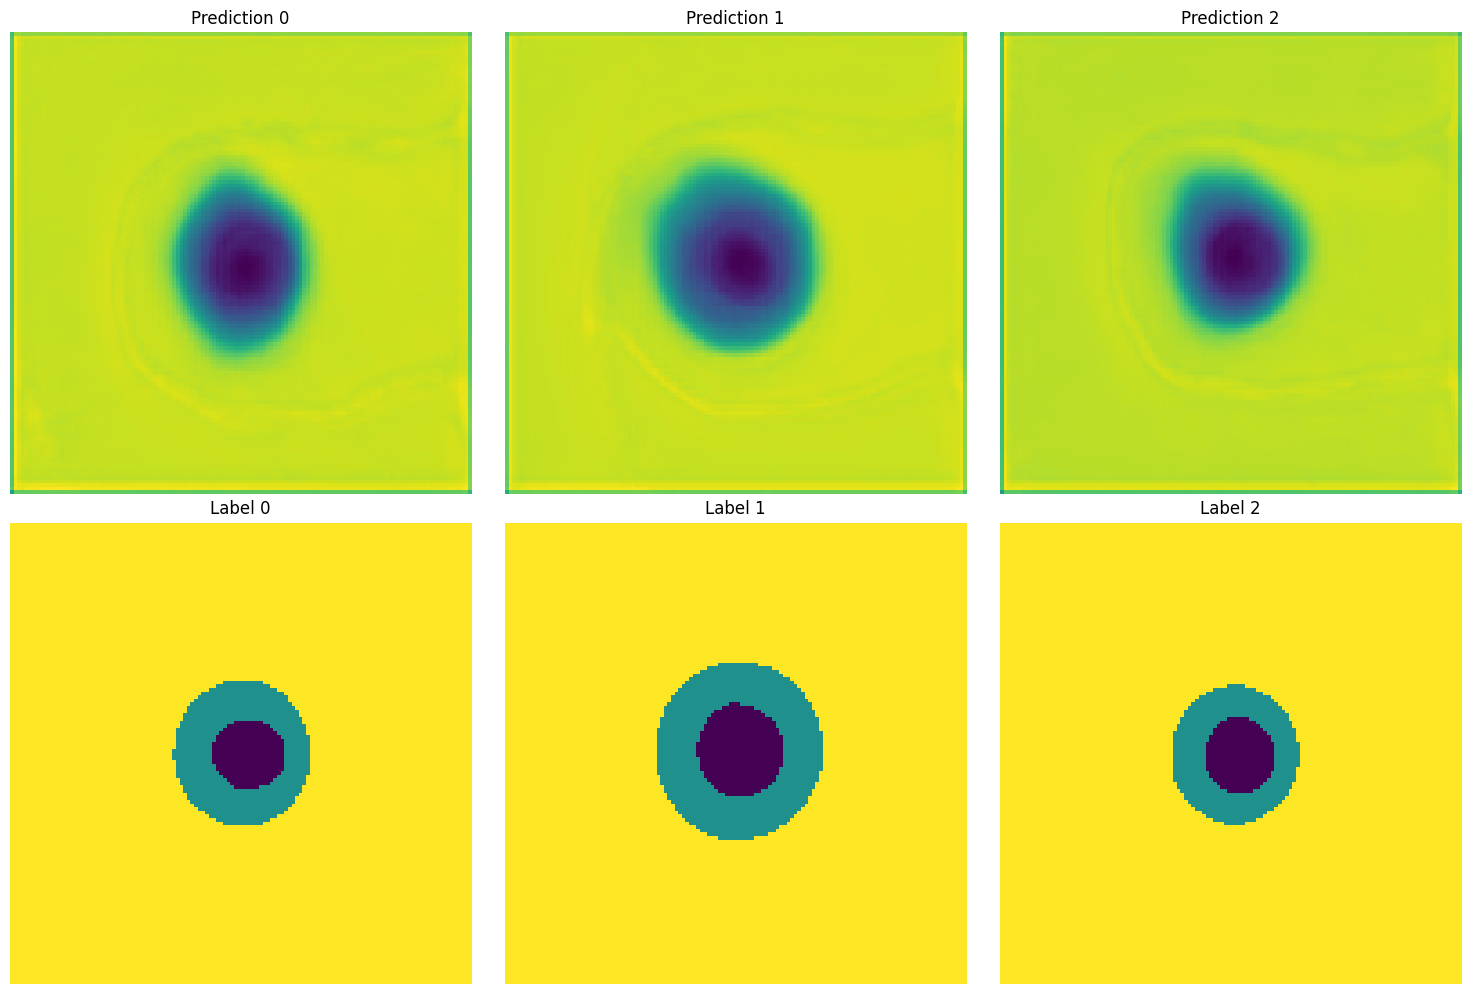

Mean Test Dice: 0.8795,   OC Val ASD: 37.4973   OD Val ASD: 28.5789


In [13]:
FACT_model.student_model.eval()
dice_total_test, oc_asd_val, od_asd_val = 0, 0, 0

# Create a 3x2 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for it, (batch) in enumerate(test_loader):
    data, labels = batch[0].to(device), batch[1].to(device)
    scores = FACT_model.student_model(data)
    labels += 1
    loss = supervised_criterion(scores, labels[:,0,:].long())
    dice_loss = Dice(scores, labels[:,0,:].long())
    labels -= 1
    oc_asd, od_asd = compute_asd(scores, labels, it)
    test_dice_coeff = 1 - dice_loss
    dice_total_test += test_dice_coeff.item()
    oc_asd_val += oc_asd
    od_asd_val += od_asd

    # Plot predictions and corresponding masks
    if it < 3:
        axs[0, it].imshow(scores[0, 2].detach().cpu().numpy())
        axs[0, it].set_title(f"Prediction {it}")
        axs[0, it].axis('off')

        axs[1, it].imshow(labels[0, 0].detach().cpu().numpy())
        axs[1, it].set_title(f"Label {it}")
        axs[1, it].axis('off')

plt.tight_layout()
plt.show()

print(f"Mean Test Dice: {dice_total_test/len(test_loader):.4f},   "
      f"OC Val ASD: {oc_asd_val/len(test_loader):.4f}   "
      f"OD Val ASD: {od_asd_val/len(test_loader):.4f}")